Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StanModels

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path_s("..", "scripts", "13")
cd(ProjDir)

### snippet 13.1

In [3]:
wd = CSV.read(rel_path("..", "data", "UCBadmit.csv"), delim=';');
df = convert(DataFrame, wd);

Preprocess data

In [4]:
df[:admit] = convert(Vector{Int}, df[:admit])
df[:applications] = convert(Vector{Int}, df[:applications])
df[:male] = [(df[:gender][i] == "male" ? 1 : 0) for i in 1:size(df, 1)];
df[:dept_id] = [Int(df[:dept][i][1])-64 for i in 1:size(df, 1)];
first(df, 5)

m13_2 = "
  data{
      int N;
      int N_depts;
      int applications[N];
      int admit[N];
      real male[N];
      int dept_id[N];
  }
  parameters{
      vector[N_depts] a_dept;
      real a;
      real bm;
      real<lower=0> sigma_dept;
  }
  model{
      vector[N] p;
      sigma_dept ~ cauchy( 0 , 2 );
      bm ~ normal( 0 , 1 );
      a ~ normal( 0 , 10 );
      a_dept ~ normal( a , sigma_dept );
      for ( i in 1:N ) {
          p[i] = a_dept[dept_id[i]] + bm * male[i];
          p[i] = inv_logit(p[i]);
      }
      admit ~ binomial( applications , p );
  }
";

Define the Stanmodel and set the output format to :mcmcchains.

In [5]:
stanmodel = Stanmodel(name="m13_2", model=m13_2,
monitors=["a", "bm", "sigma_dept", "a_dept.1", "a_dept.2", "a_dept.3",
"a_dept.4", "a_dept.5", "a_dept.6"],
output_format=:mcmcchains);


File /Users/rob/.julia/dev/StanModels/scripts/13/tmp/m13_2.stan will be updated.



Input data for cmdstan

In [6]:
ucdata = Dict("N" => size(df, 1), "N_depts" => maximum(df[:dept_id]), "admit" => df[:admit],
"applications" => df[:applications],  "dept_id"=> df[:dept_id], "male" => df[:male]);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, ucdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1, Chain2, Chain3, Chain4
Samples per chain = 1000
parameters        = a_dept.1, a_dept.2, a_dept.3, a_dept.4, a_dept.5, a_dept.6, a, bm, sigma_dept

Empirical Posterior Estimates:
parameters
             Mean    SD   Naive SE  MCSE   ESS
         a -0.5810 0.6613   0.0105 0.0146 1000
  a_dept.1  0.6781 0.0993   0.0016 0.0020 1000
  a_dept.2  0.6318 0.1160   0.0018 0.0022 1000
  a_dept.3 -0.5821 0.0747   0.0012 0.0012 1000
  a_dept.4 -0.6143 0.0855   0.0014 0.0013 1000
  a_dept.5 -1.0585 0.0994   0.0016 0.0016 1000
  a_dept.6 -2.6057 0.1562   0.0025 0.0022 1000
        bm -0.0977 0.0812   0.0013 0.0017 1000
sigma_dept  1.4785 0.5630   0.0089 0.0149 1000

Quantiles:
parameters
             2.5%   25.0%   50.0%   75.0%   97.5% 
         a -3.8356 -0.9618 -0.5948 -0.1983  3.3327
  a_dept.1  0.3502  0.6125  0.6758  0.7439  1.0100
  a_dept.2  0.2235  0.5527  0.6316  0.7090  1.1565
  a_dept.3 -0

Plot the density of posterior draws

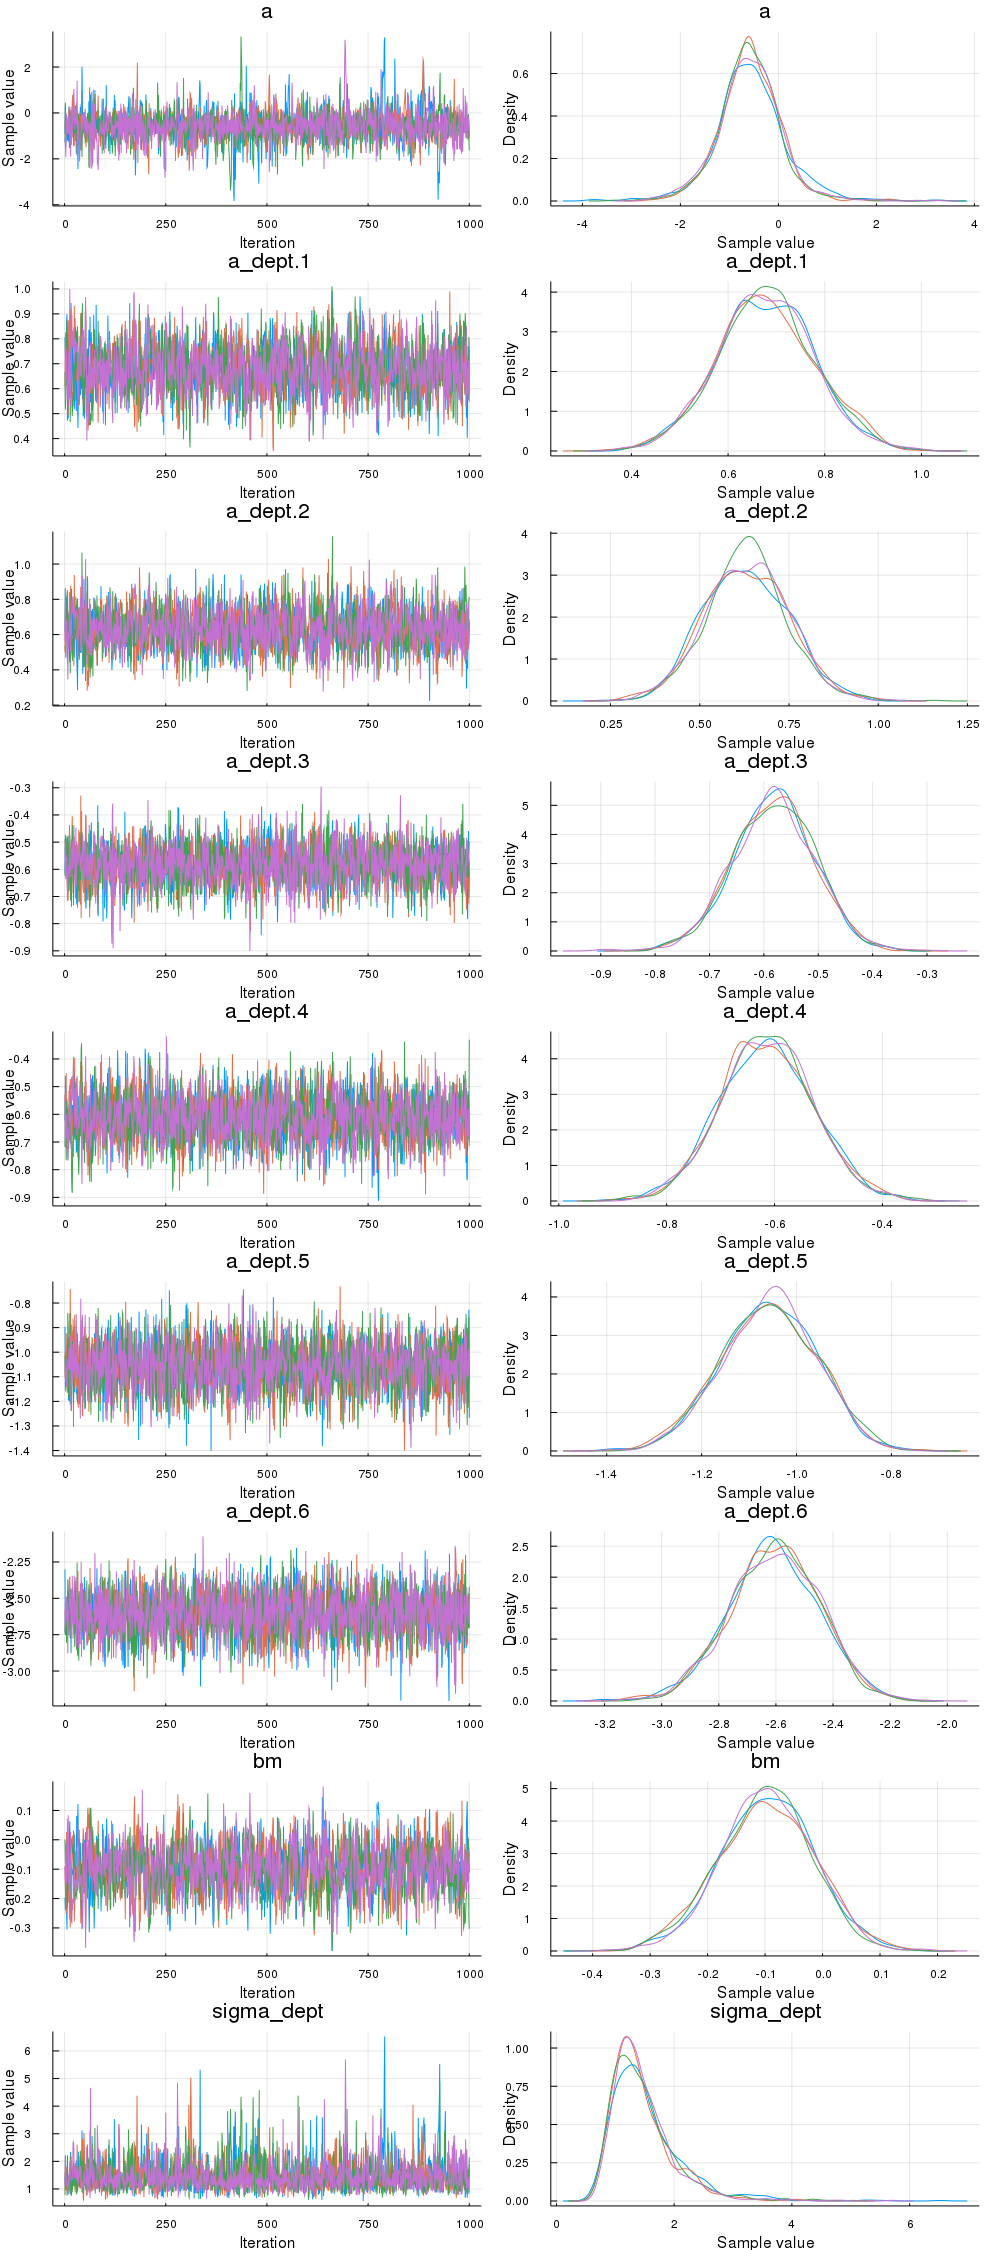

In [8]:
plot(chn)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*